# Polymers

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

In [17]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# 1b)Petar lukter

def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.

In [19]:
def createDirectionList(polymerPart):
    dir = np.zeros(len(polymerPart-1))
    for i in range(len(polymerPart)-1):
        d = polymerPart[i+1] - polymerPart[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


In [38]:
def rotatePolymer(polymer, coord, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    rotatingBase = -1
    N = len(polymer)
    # finds index of monomer to rotate around
    for i in range(len(polymer)):
        if np.array_equal(polymer[i],coord):
            rotatingBase = i
            break
    rotatingLeft = rotatingBase <= len(polymer)//2

    directionList = createDirectionList(polymer)
    if rotatingLeft:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4

    #IDEA: Calculate direction change for every polymer to be rotated. Then use this info to recalculate the position based of the rotation base.
    print(directionList)

    if rotatingLeft:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, len(polymer)):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

        

p = createPolymer(10)
print(p[1:,])
coord = np.array([3,5])
coord2 = np.array([8,5])
p = rotatePolymer(p,coord)
print(p)
q = np.copy(p)
q = rotatePolymer(q, coord2, clockwise=True)
print(q)

        



[[1. 5.]
 [2. 5.]
 [3. 5.]
 [4. 5.]
 [5. 5.]
 [6. 5.]
 [7. 5.]
 [8. 5.]
 [9. 5.]]
[3. 3. 3. 0. 0. 0. 0. 0. 0. 0.]
[[3. 8.]
 [3. 7.]
 [3. 6.]
 [3. 5.]
 [4. 5.]
 [5. 5.]
 [6. 5.]
 [7. 5.]
 [8. 5.]
 [9. 5.]]
[3. 3. 3. 0. 0. 0. 0. 0. 3. 3.]
[[3. 8.]
 [3. 7.]
 [3. 6.]
 [3. 5.]
 [4. 5.]
 [5. 5.]
 [6. 5.]
 [7. 5.]
 [8. 5.]
 [8. 4.]]


1d)

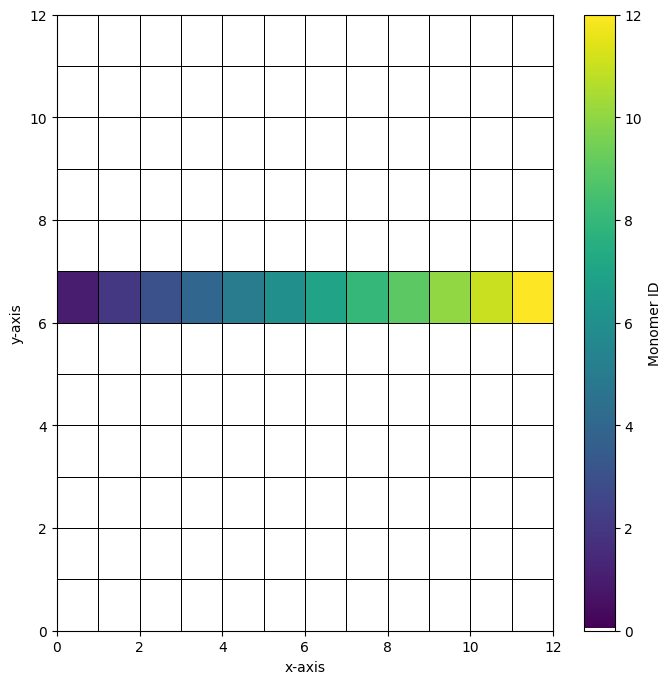

[[3. 8.]
 [3. 7.]
 [3. 6.]
 [3. 5.]
 [4. 5.]
 [5. 5.]
 [6. 5.]
 [7. 5.]
 [8. 5.]
 [9. 5.]]


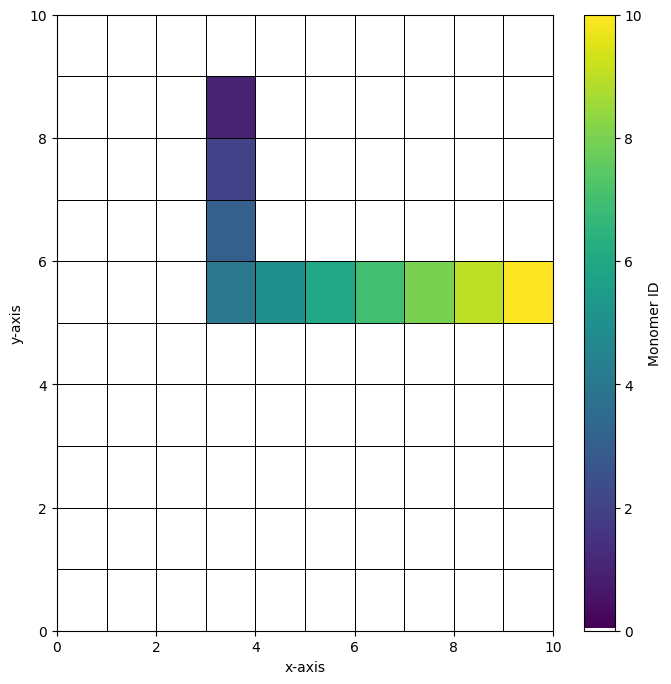

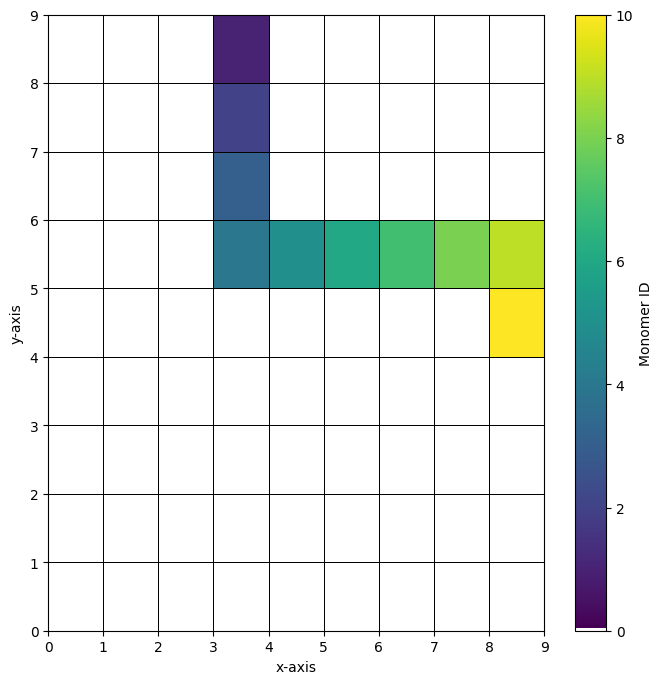

In [39]:
from matplotlib.colors import ListedColormap

def visualize_polymer(polymer):
    # Polymer dimentions
    M = int(np.max(polymer[:, 0]) + 1)

    # Empty grid
    grid = np.zeros((M, M))

    # putting the monomers into the grid
    for i, (x, y) in enumerate(polymer):
        grid[int(y), int(x)] = i + 1  

    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Visualizing
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

polymer = createPolymer(12)
visualize_polymer(polymer)
print(p)
visualize_polymer(p)
visualize_polymer(q)





In [9]:
# 1e
def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    length = len(polymer)
    for punkt in polymer:
        if any(polymer) == punkt:
            return True
        else:
            return False
    if length == N:
        return True
    else:
        return False